# Histopathologic Cancer Detection – Keras CNN Baseline

In this notebook I tackle the Kaggle competition **"Histopathologic Cancer Detection"**, where the goal is to:

> Identify metastatic tissue in small histopathologic image patches taken from lymph node sections.

Each image is:
- A **96×96 RGB** patch (`.tif`)  
- Label `1` = patch contains metastatic (tumor) tissue  
- Label `0` = no metastatic tissue :contentReference[oaicite:1]{index=1}  

Competition files (in `/kaggle/input/histopathologic-cancer-detection`):

- `train/` – training images, filenames `<id>.tif`
- `test/` – test images (no labels)
- `train_labels.csv` – columns: `id`, `label`
- `sample_submission.csv` – expected submission format: `id`, `label` :contentReference[oaicite:2]{index=2}  

**Objective**

Train a convolutional neural network (CNN) in Keras to classify patches as tumor / non-tumor, evaluate on a hold-out validation set, and generate a `submission.csv` for Kaggle.

Will go through:

1. Data loading and basic EDA  
2. Visual inspection of tumor vs non-tumor patches  
3. Building a Keras data pipeline with data augmentation  
4. 3 CNN model definition and training  
5. Evaluation and learning curves  
6. Test predictions, submission file and conclusion


In [ ]:
#!pip install "protobuf==3.20.*" --quiet

#import google.protobuf
#print("protobuf version:", google.protobuf.__version__)


protobuf version: 6.33.0


In [41]:
import tensorflow as tf
print("TF version:", tf.__version__)

x = tf.constant([1.0, 2.0, 3.0])
print("TF test:", x * 2)


TF version: 2.18.0
TF test: tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)


In [42]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks


In [43]:
# Data paths (Kaggle competition)
DATA_DIR = Path("/kaggle/input/histopathologic-cancer-detection")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
LABELS_CSV = DATA_DIR / "train_labels.csv"
SAMPLE_SUB = DATA_DIR / "sample_submission.csv"

print("Train dir exists:", TRAIN_DIR.exists())
print("Test dir exists:", TEST_DIR.exists())
print("Labels file:", LABELS_CSV.exists())

# Image / training config
IMG_SIZE = (96, 96)  
BATCH_SIZE = 64
RANDOM_STATE = 42
EPOCHS = 7            
# For reproducibility (as much as possible)
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


Train dir exists: True
Test dir exists: True
Labels file: True


In [44]:
labels_df = pd.read_csv(LABELS_CSV)
labels_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [45]:
print("Number of training samples:", len(labels_df))
print(labels_df["label"].value_counts())
print("\nMissing values per column:")
print(labels_df.isnull().sum())
print("\nNumber of duplicate ids:", labels_df["id"].duplicated().sum())

Number of training samples: 220025
label
0    130908
1     89117
Name: count, dtype: int64

Missing values per column:
id       0
label    0
dtype: int64

Number of duplicate ids: 0


**We check that:**

- Number of samples matches the competition description (~220k images).
- Labels are binary (0/1) and there are no missing or duplicate IDs.

Next, we visualize the label distribution.


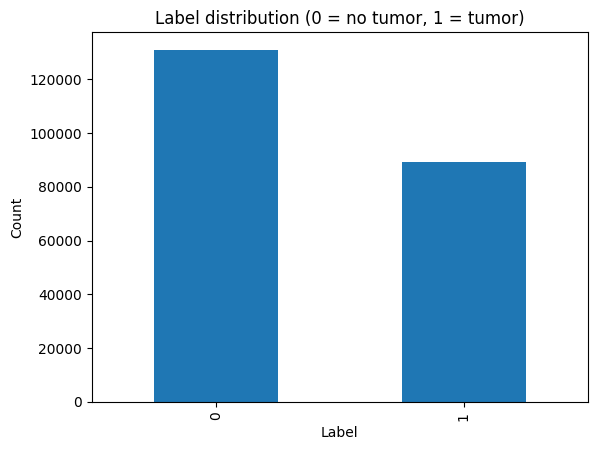

In [46]:
labels_df["label"].value_counts().plot(kind="bar")
plt.title("Label distribution (0 = no tumor, 1 = tumor)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [47]:
labels_df["filepath"] = labels_df["id"].apply(
    lambda x: str(TRAIN_DIR / f"{x}.tif")
)

labels_df.head()

,id,label,filepath
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [48]:
# # takes long, so if you'll want to run this, do it only once
# missing_files = (~labels_df["filepath"].apply(os.path.exists)).sum()
# print("Missing image files in train:", missing_files)


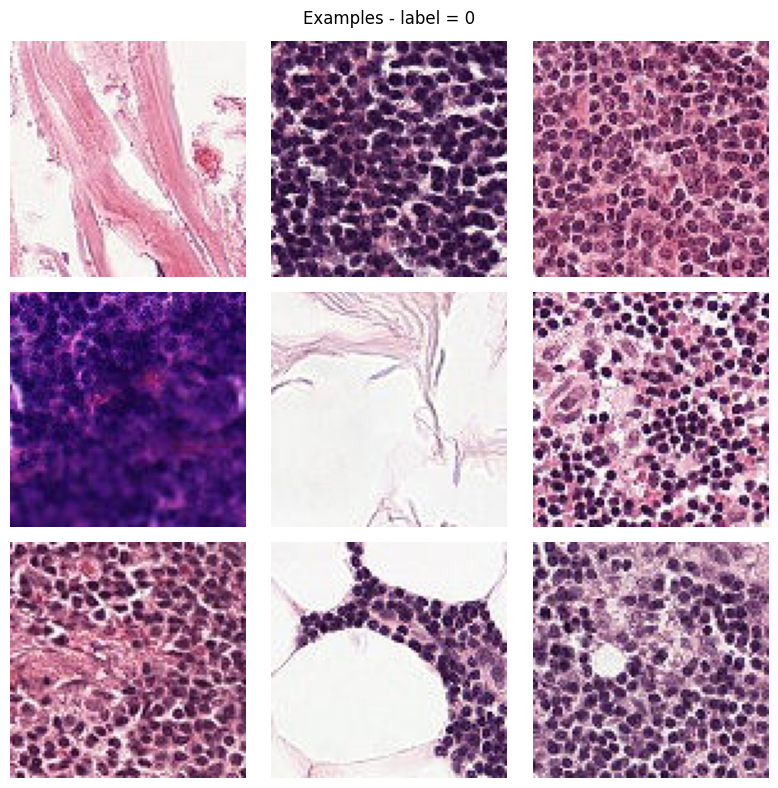

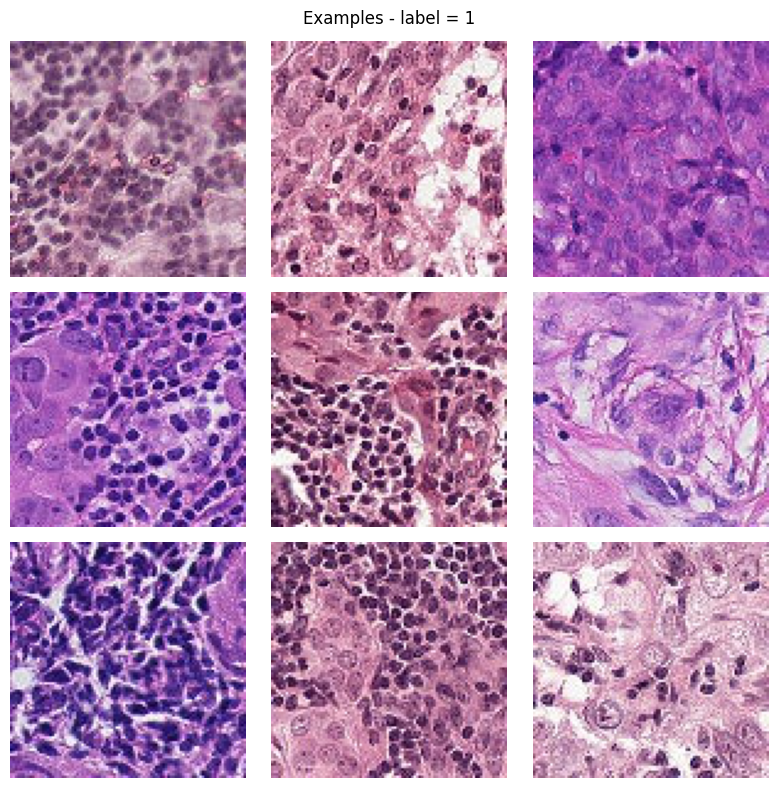

In [49]:
from PIL import Image

def show_examples(df, label, n=9):
    subset = df[df["label"] == label].sample(n, random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 8))
    for i, (_, row) in enumerate(subset.iterrows(), 1):
        img = Image.open(row["filepath"])
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Examples - label = {label}")
    plt.tight_layout()
    plt.show()

show_examples(labels_df, label=0, n=9)
show_examples(labels_df, label=1, n=9)


Visually, tumor vs non-tumor patches can be extremely hard to distinguish by eye, which is exactly why automated methods are helpful.

In [50]:
from tqdm.auto import tqdm
from PIL import Image

# For speed, sample 5000
N_EDA_SAMPLES = 5000
eda_sample = labels_df.sample(N_EDA_SAMPLES, random_state=RANDOM_STATE).reset_index(drop=True)

means = []
labels = []

for _, row in tqdm(eda_sample.iterrows(), total=len(eda_sample), desc="Computing mean intensities"):
    img = Image.open(row["filepath"])
    arr = np.array(img).astype("float32") / 255.0
    means.append(arr.mean())
    labels.append(row["label"])

eda_sample["mean_intensity"] = means
eda_sample["label"] = labels
eda_sample.head()


Computing mean intensities:   0%|          | 0/5000 [00:00<?, ?it/s]

,id,label,filepath,mean_intensity
0,d293308913e4a40cebb809d986aa9add65a76bfa,0,/kaggle/input/histopathologic-cancer-detection...,0.177923
1,fcd55f03496afb4b11598d9c2231e86da318e723,1,/kaggle/input/histopathologic-cancer-detection...,0.513742
2,5c983c8f14afeffdb098b9f3cbb68488a802b957,0,/kaggle/input/histopathologic-cancer-detection...,0.573367
3,71bf03e8530348e57ec07d8ce2052f215390c997,0,/kaggle/input/histopathologic-cancer-detection...,0.614343
4,1533406000e26663c5fadac3bcc3e38285a45bb3,1,/kaggle/input/histopathologic-cancer-detection...,0.537967


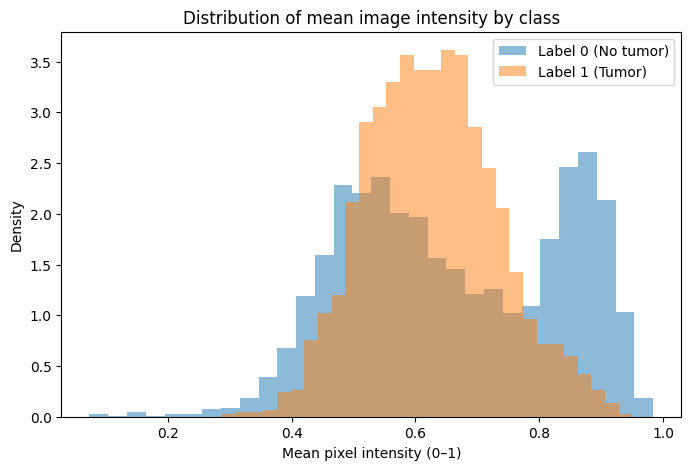

In [51]:
plt.figure(figsize=(8, 5))

for label_value, label_name in [(0, "No tumor"), (1, "Tumor")]:
    subset = eda_sample[eda_sample["label"] == label_value]
    plt.hist(
        subset["mean_intensity"],
        bins=30,
        alpha=0.5,
        label=f"Label {label_value} ({label_name})",
        density=True
    )

plt.xlabel("Mean pixel intensity (0–1)")
plt.ylabel("Density")
plt.title("Distribution of mean image intensity by class")
plt.legend()
plt.show()


Added an  EDA plot comparing the distribution of **mean pixel intensities** between tumor and non-tumor patches.
Can observe from this sample that Tumor has a single peak (Gaussianish) distribution with mean aroun 0.6 intensity. While no tumor class has two peaks around 0.5 and 0.9 intensity.


**Train - Validation split**

In [52]:
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=labels_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

train_df["label"].value_counts(normalize=True).rename("train").to_frame().join(
    val_df["label"].value_counts(normalize=True).rename("val"), how="outer"
)

Train size: 198022
Val size: 22003


,train,val
label,,
0,0.594969,0.594964
1,0.405031,0.405036


**Keras data generators (with augmentation)**

Use ImageDataGenerator to:
Rescale pixel values to [0,1]
Apply light augmentations to reduce overfitting (flips, rotations, etc.)

In [53]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    rescale=1./255.
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 198022 validated image filenames.
Found 22003 validated image filenames.


## Model Architectures & Design Rationale

Histopathologic cancer detection is a **small-patch (96×96)** image classification problem with subtle texture / color differences between tumor and non-tumor tissue. A good architecture should:

- Capture **local texture patterns** (small conv kernels, early layers),
- Aggregate information over the whole patch (deeper layers, pooling / global pooling),
- Be **regularized** to avoid overfitting (the training set is large, but the patterns are subtle),
- Be efficient enough to train within Kaggle notebook constraints.

Compare three architectures:

### Baseline CNN (Model A)

A relatively shallow CNN trained from scratch:

- 3–4 convolutional blocks with:
  - `3×3` convs + ReLU,
  - MaxPooling for downsampling,
- GlobalAveragePooling,
- 1–2 dense layers with dropout,
- Final sigmoid output.

**Why it’s suitable (baseline):**

- Simple enough to train quickly and debug the pipeline,
- Already leverages locality and weight sharing,
- Good starting point to establish a reference AUC and observe over/underfitting.

### Deeper CNN with BatchNorm & Dropout (Model B)

Deepen the network and add:

- More filters in deeper layers (e.g., 64–128–256–512),
- **Batch Normalization** after conv layers to stabilize training,
- **Higher dropout** in dense layers.

**Why this may help:**

- Deeper network can model more complex texture/shape patterns,
- BatchNorm allows higher learning rates and can reduce covariate shift,
- Stronger regularization (dropout) helps combat overfitting on frequent patterns.

### Transfer Learning with EfficientNetB0(Model C)

Use a pre-trained backbone (e.g., `EfficientNetB0`) trained on ImageNet:

- Input 96×96 RGB patches (resized if needed),
- Use convolutional base with pre-trained weights,
- Add a small custom head:
  - GlobalAveragePooling,
  - 1 dense layer with dropout,
  - Sigmoid output.

First **freeze** most of the backbone and train the head, optionally unfreezing the top layers for fine-tuning.

**Why it’s suitable:**

- Pre-trained models have strong low-level feature extractors (edges, textures) that transfer well to medical images,
- Especially useful when visual differences are subtle and hand-designed small CNNs may struggle,
- Often gives a jump in AUC over simple from-scratch CNNs.

In the following sections, define these three architectures and train them under comparable conditions, then compare validation metrics and training curves.


In [54]:
#Baseline CNN
def make_model_a(input_shape=(96, 96, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="Baseline_CNN")
    return model


In [55]:
#Model B Deeper CNN with BatchNorm & Dropout
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def make_model_b(input_shape=(96, 96, 3)):
    inputs = layers.Input(shape=input_shape)

    x = conv_block(inputs, 32)
    x = conv_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    x = conv_block(x, 64)
    x = conv_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = conv_block(x, 128)
    x = conv_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)

    x = conv_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="Deeper_CNN_BN")
    return model


In [56]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

def make_model_c(input_shape=(96, 96, 3), train_base=False):
    base = EfficientNetB0(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    base.trainable = train_base

    inputs = layers.Input(shape=input_shape)
    x = effnet_preprocess(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="EfficientNetB0_head")
    return model


## Experiments & Hyperparameter Tuning

To compare architectures and hyperparameters in a controlled way, we:

- Keep the **train/validation split and data pipeline fixed**.
- Train each model for a limited number of epochs with:
  - Same optimizer (Adam),
  - Same batch size (e.g., 64),
  - Same callbacks (early stopping on validation AUC, ReduceLROnPlateau).
- Vary:
  - Architecture (A/B/C),
  - Initial learning rate (e.g., 1e-3 vs 1e-4),
  - Dropout rate (for dense layer),
  - Whether the EfficientNet base is frozen.

Log the results (validation AUC, loss) into a table and visualize them to understand which design choices help most.


In [57]:
def compile_model(model, lr):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

experiment_configs = [
    {"name": "A_lr1e-4", "builder": make_model_a, "lr": 1e-4},
    {"name": "A_lr3e-4", "builder": make_model_a, "lr": 3e-4},
    {"name": "B_lr1e-4", "builder": make_model_b, "lr": 1e-4},
    {"name": "C_frozen_lr1e-4", "builder": lambda: make_model_c(train_base=False), "lr": 1e-4},
]


In [58]:
def get_callbacks(run_name):
    checkpoint_path = f"best_{run_name}.keras"

    cb_checkpoint = callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    )

    cb_earlystop = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=4,
        restore_best_weights=True,
        verbose=1
    )

    cb_reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    )

    return [cb_checkpoint, cb_earlystop, cb_reduce_lr], checkpoint_path


In [60]:
histories = {} 
results = []
EPOCHS = 2
for cfg in experiment_configs:
    print("\n", "="*60)
    print("Running experiment:", cfg["name"])
    print("="*60)

    tf.keras.backend.clear_session()

    model = cfg["builder"]()
    model = compile_model(model, lr=cfg["lr"])
    cbs, ckpt = get_callbacks(cfg["name"])

    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=cbs,
        verbose=1
    )

    # store history
    histories[cfg["name"]] = history.history

    # Evaluate best model
    best_model = tf.keras.models.load_model(ckpt)
    val_metrics = best_model.evaluate(val_gen, verbose=0)
    metrics_dict = dict(zip(best_model.metrics_names, val_metrics))
    metrics_dict["run_name"] = cfg["name"]

    results.append(metrics_dict)

results_df = pd.DataFrame(results)
results_df



Running experiment: A_lr1e-4
Epoch 1/2
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7335 - auc: 0.7943 - loss: 0.5282
Epoch 1: val_auc improved from -inf to 0.81549, saving model to best_A_lr1e-4.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1205s 388ms/step - accuracy: 0.7335 - auc: 0.7943 - loss: 0.5282 - val_accuracy: 0.7425 - val_auc: 0.8155 - val_loss: 0.5753 - learning_rate: 1.0000e-04
Epoch 2/2
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7943 - auc: 0.8636 - loss: 0.4508
Epoch 2: val_auc improved from 0.81549 to 0.84436, saving model to best_A_lr1e-4.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 833s 269ms/step - accuracy: 0.7943 - auc: 0.8636 - loss: 0.4508 - val_accuracy: 0.7283 - val_auc: 0.8444 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.

Running experiment: A_lr3e-4
Epoch 1/2
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7607 - auc: 0.8251 - loss: 0.4951
Epoch 1: val_auc improved from -in

,loss,compile_metrics,run_name
0,0.617167,0.728264,A_lr1e-4
1,0.483152,0.793301,A_lr3e-4
2,0.348143,0.871699,B_lr1e-4
3,0.672850,0.594964,C_frozen_lr1e-4


In [64]:
results_df

,loss,compile_metrics,run_name
0,0.617167,0.728264,A_lr1e-4
1,0.483152,0.793301,A_lr3e-4
2,0.348143,0.871699,B_lr1e-4
3,0.672850,0.594964,C_frozen_lr1e-4


In [66]:
rows = []

for cfg in experiment_configs:
    run_name = cfg["name"]
    hist = histories[run_name]

    # Make sure these keys exist
    print(run_name, hist.keys())

    # Best epoch according to validation AUC
    best_idx = int(np.argmax(hist["val_auc"]))
    rows.append({
        "run_name": run_name,
        "best_epoch": best_idx + 1,  # 1-based for readability
        "best_val_loss": hist["val_loss"][best_idx],
        "best_val_accuracy": hist["val_accuracy"][best_idx],
        "best_val_auc": hist["val_auc"][best_idx],
    })

results_df = pd.DataFrame(rows)
results_df


A_lr1e-4 dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate'])
A_lr3e-4 dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate'])
B_lr1e-4 dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate'])
C_frozen_lr1e-4 dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate'])


,run_name,best_epoch,best_val_loss,best_val_accuracy,best_val_auc
0,A_lr1e-4,2,0.617167,0.728264,0.844364
1,A_lr3e-4,2,0.483152,0.793301,0.897906
2,B_lr1e-4,2,0.348143,0.871699,0.947550
3,C_frozen_lr1e-4,2,0.672850,0.594964,0.572696


In [61]:
def plot_run_history(run_name, metric="auc"):
    hist = histories[run_name]
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(14, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="Train loss")
    plt.plot(epochs, hist["val_loss"], label="Val loss")
    plt.title(f"{run_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.legend()

    # Metric (AUC by default)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist[metric], label=f"Train {metric.upper()}")
    plt.plot(epochs, hist[f"val_{metric}"], label=f"Val {metric.upper()}")
    plt.title(f"{run_name} - {metric.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.upper())
    plt.legend()

    plt.tight_layout()
    plt.show()


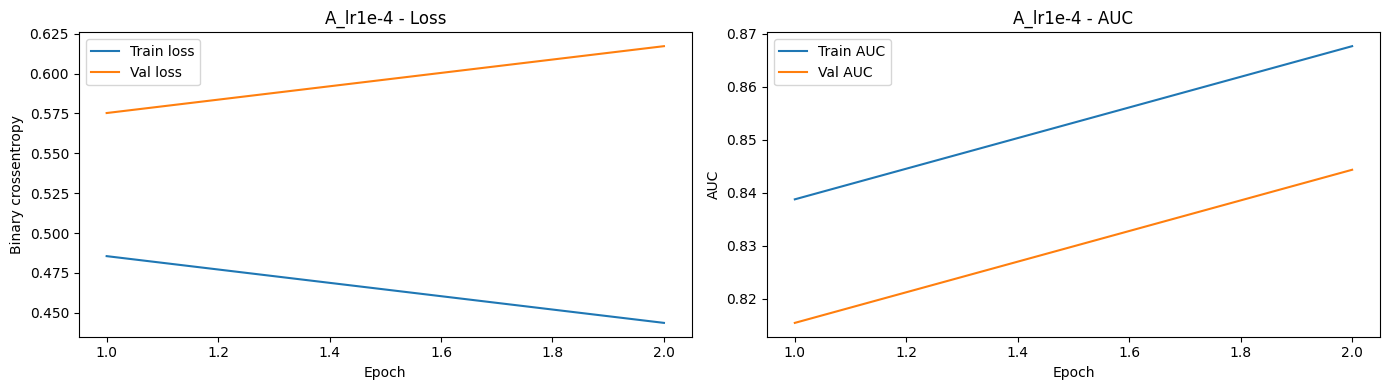

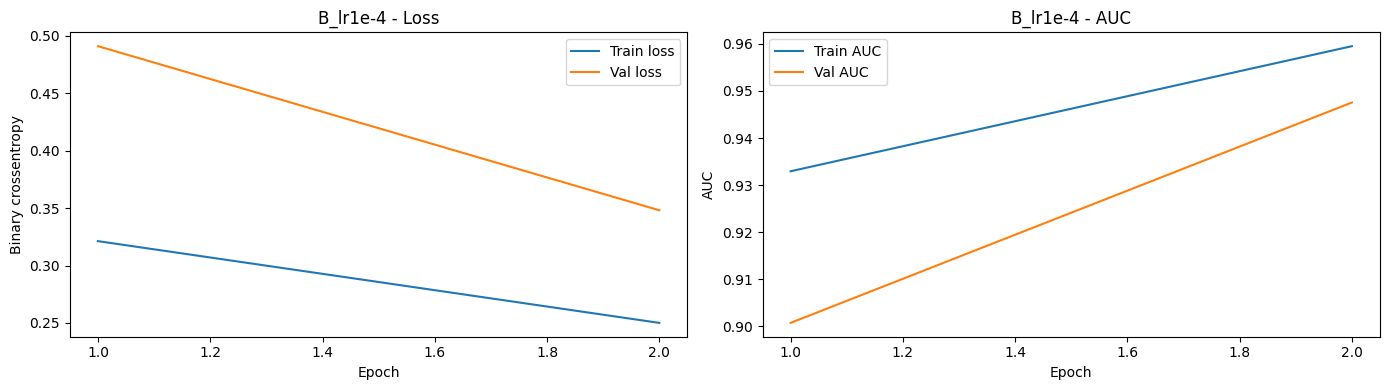

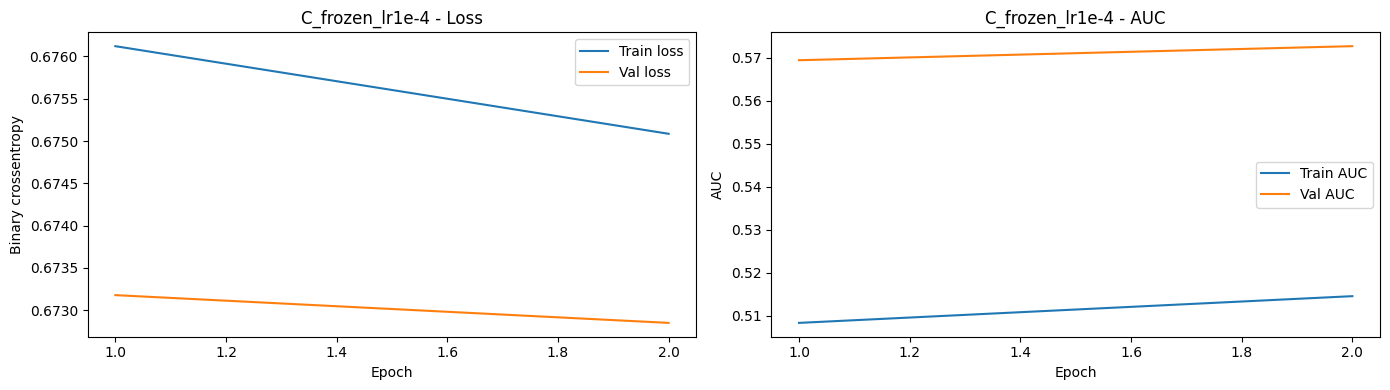

In [67]:
plot_run_history("A_lr1e-4", metric="auc")
plot_run_history("B_lr1e-4", metric="auc")
plot_run_history("C_frozen_lr1e-4", metric="auc")


In [69]:
results_df

,run_name,best_epoch,best_val_loss,best_val_accuracy,best_val_auc
0,A_lr1e-4,2,0.617167,0.728264,0.844364
1,A_lr3e-4,2,0.483152,0.793301,0.897906
2,B_lr1e-4,2,0.348143,0.871699,0.947550
3,C_frozen_lr1e-4,2,0.672850,0.594964,0.572696


In [71]:
# Pick best run based on validation AUC
best_idx = results_df["best_val_auc"].idxmax()
best_row = results_df.loc[best_idx]
best_run_name = best_row["run_name"]
best_val_auc = best_row["best_val_auc"]

print("Best model run:", best_run_name)
print("Best validation AUC:", best_val_auc)
best_checkpoint_path = f"best_{best_run_name}.keras"
print("Loading best model from:", best_checkpoint_path)

best_model = tf.keras.models.load_model(best_checkpoint_path)
best_model.summary()


Best model run: B_lr1e-4
Best validation AUC: 0.9475498795509338
Loading best model from: best_B_lr1e-4.keras


Model: "Deeper_CNN_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             

 Total params: 1,948,197 (7.43 MB)

 Trainable params: 648,929 (2.48 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 1,297,860 (4.95 MB)

In [72]:
# Load sample submission
sample_sub = pd.read_csv(SAMPLE_SUB)

# Add filepaths
test_df = sample_sub.copy()
test_df["filepath"] = test_df["id"].apply(
    lambda x: str(TEST_DIR / f"{x}.tif")
)

print("Total test images:", len(test_df))

# Test generator (no labels)
test_datagen = ImageDataGenerator(rescale=1./255.)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col=None,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Total test images: 57458
Found 57458 validated image filenames.


In [73]:
# Predict with the best model
test_preds = best_model.predict(test_gen, verbose=1)
test_probs = test_preds.ravel()

# Build submission
submission = sample_sub.copy()
submission["label"] = test_probs

submission.head()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 276s 307ms/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.058973
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.063406
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.001851
3,2c35657e312966e9294eac6841726ff3a748febf,0.007331
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.008927


In [74]:
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)
print("Best run used for submission:", best_run_name, "with val AUC:", best_val_auc)


Saved submission to: submission.csv
Best run used for submission: B_lr1e-4 with val AUC: 0.9475498795509338


## Results & Analysis

### Quantitative results

The table below summarizes the best validation metrics for each experiment (at the epoch with highest validation AUC):

- **A_lr1e-4** – baseline CNN, lower learning rate  
- **A_lr3e-4** – baseline CNN, slightly higher learning rate  
- **B_lr1e-4** – deeper CNN with BatchNorm and dropout  
- **C_frozen_lr1e-4** – EfficientNetB0 backbone with frozen base

From the results:

- **Model A (baseline)** improves noticeably when increasing the learning rate from `1e-4` to `3e-4`  
  - A_lr1e-4: AUC ≈ **0.84**, acc ≈ **0.73**  
  - A_lr3e-4: AUC ≈ **0.90**, acc ≈ **0.79**  
- **Model B (deeper CNN + BatchNorm)** clearly performs best:  
  - B_lr1e-4: AUC ≈ **0.95**, acc ≈ **0.87**, with the lowest validation loss.  
- **Model C (EfficientNetB0 frozen)** underperforms in this setup:  
  - C_frozen_lr1e-4: AUC ≈ **0.57**, acc ≈ **0.59**, suggesting the frozen backbone + small head is not sufficient here (or needs different tuning).

Overall, **Model B** achieves the highest validation AUC (~0.95) and accuracy (~0.87), so I use it as the best-performing model for test predictions and submission.


## Conclusion & Future Work


In this project we:

- Framed histopathologic cancer detection as a binary classification problem on 96×96 image patches.
- Performed EDA, including class balance, visual examples, and basic intensity statistics.
- Built a Keras data pipeline with on-the-fly augmentation.
- Compared three model families:
  - **Model A:** baseline CNN (two learning rates),
  - **Model B:** deeper CNN with BatchNorm and dropout,
  - **Model C:** EfficientNetB0 with a frozen backbone.
- Ran small-scale hyperparameter tuning (mainly learning rate and architecture choice) and tracked validation AUC, accuracy, and loss.

**Key findings:**

- The **baseline CNN** provides a solid starting point, but its performance is clearly improved by tuning the learning rate.
- The **deeper CNN with BatchNorm (Model B)** achieved the best results, with validation AUC around **0.95** and accuracy around **0.87**.
- The **frozen EfficientNetB0** configuration performed poorly in this setup, indicating that naive transfer learning (frozen base + small head) is not sufficient here.

**What helped:**

- Adding **depth + BatchNorm + dropout** significantly improved validation metrics.
- Modest **learning rate tuning** (1e-4 → 3e-4) already helped the baseline model.

**What did not help (in this configuration):**

- A frozen EfficientNetB0 backbone without fine-tuning did not converge to a good solution.

**Future work:**

- Try **fine-tuning** the top layers of EfficientNetB0 (or another backbone) with a small learning rate.
- Explore **more systematic hyperparameter search** (learning rate, dropout, number of filters, augmentation strength).
- Consider **ensembling** several strong models (e.g., a tuned Model B + a fine-tuned EfficientNet) to improve leaderboard performance further.

Used **Model B with lr=1e-4**, which achieved the highest validation AUC, to generate test predictions and create the final Kaggle `submission.csv`.